In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Исходные данные

In [2]:
df = pd.read_csv('data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
X = df.drop(columns=['Class'], axis=1)
y = df['Class']

In [4]:
y[y == 1].shape[0]/y.shape[0]

0.001727485630620034

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    print(y_train_fold[y_train_fold == 1].shape[0]/y_train_fold.shape[0])
    print(y_val_fold[y_val_fold == 1].shape[0]/y_val_fold.shape[0])

0.0017248643808921893
0.001738008400373935
0.001731436433899287
0.0017248643808921893
0.001731436433899287
0.0017248643808921893


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances

In [8]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

### class_weight = balanced

In [9]:
def objective_balanced(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': 'balanced',
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [10]:
study_balanced = optuna.create_study(direction='maximize', study_name='balanced_weight')
study_custom = optuna.create_study(direction='maximize', study_name='custom_weight')
study_none = optuna.create_study(direction='maximize', study_name='no_weight')

[I 2026-01-16 12:14:12,708] A new study created in memory with name: balanced_weight
[I 2026-01-16 12:14:12,708] A new study created in memory with name: custom_weight
[I 2026-01-16 12:14:12,708] A new study created in memory with name: no_weight


In [ ]:
study_balanced.optimize(objective_balanced, n_trials=200, show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-01-16 12:14:19,257] Trial 0 finished with value: 0.7517013857549827 and parameters: {'n_estimators': 240, 'max_depth': 40, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': 0.3, 'bootstrap': True, 'max_samples': 0.6835932196360253}. Best is trial 0 with value: 0.7517013857549827.
[I 2026-01-16 12:14:23,047] Trial 1 finished with value: 0.7941057672576816 and parameters: {'n_estimators': 129, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_features': 0.5, 'bootstrap': True, 'max_samples': 0.5983757606065718}. Best is trial 1 with value: 0.7941057672576816.
[I 2026-01-16 12:14:28,379] Trial 2 finished with value: 0.7912645207687099 and parameters: {'n_estimators': 155, 'max_depth': 30, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': 0.7, 'bootstrap': True, 'max_samples': 0.6283451615130589}. Best is trial 1 with value: 0.7941057672576816.
[I 2026-01-16 12:14:38,347] Trial 3 finished with value: 0.8131493775221562 and parameters:

In [12]:
fig = plot_optimization_history(study_balanced)
fig.show()

In [13]:
fig = plot_param_importances(study_balanced)
fig.show()

In [14]:
best_params_balanced = study_balanced.best_params
best_params_balanced

{'n_estimators': 285,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'max_features': 0.7,
 'bootstrap': False}

In [15]:
complete_params = {
    **best_params_balanced,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
    'max_samples': None,
}

In [ ]:
model_balanced = ExtraTreesClassifier(**complete_params)
model_balanced.fit(X_trainval, y_trainval)
y_test_pred = model_balanced.predict_proba(X_test)[:, 1]
test_pr_auc_balanced = average_precision_score(y_test, y_test_pred)
test_pr_auc_balanced

0.8720642634646435

### class_weight = {0: 1, 1: fraud_weight}

In [17]:
def objective_custom_weight(trial):
    fraud_weight = trial.suggest_float('fraud_weight', low=10, high=500, log=True)
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': {0: 1, 1: fraud_weight},
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [18]:
study_custom.optimize(objective_custom_weight, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-01-16 12:40:01,011] Trial 0 finished with value: 0.7675684020136639 and parameters: {'fraud_weight': 371.492115515923, 'n_estimators': 180, 'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7675684020136639.
[I 2026-01-16 12:40:06,564] Trial 1 finished with value: 0.7958229633249673 and parameters: {'fraud_weight': 50.33017634041196, 'n_estimators': 226, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 13, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.7460080230852597}. Best is trial 1 with value: 0.7958229633249673.
[I 2026-01-16 12:40:11,781] Trial 2 finished with value: 0.791607371721903 and parameters: {'fraud_weight': 14.776371162932788, 'n_estimators': 173, 'max_depth': 20, 'min_samples_leaf': 9, 'min_samples_split': 16, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.7958229633249673.
[I 2026-01-16 12:40:17,039] Trial 3 finished w

In [19]:
fig = plot_optimization_history(study_custom)
fig.show()

In [20]:
fig = plot_param_importances(study_custom)
fig.show()

In [21]:
best_params_custom = study_custom.best_params
best_params_custom

{'fraud_weight': 17.57709587978937,
 'n_estimators': 205,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'max_features': 0.5,
 'bootstrap': False}

In [22]:
fraud_weight = best_params_custom['fraud_weight']
class_weight_dict = {0: 1, 1: fraud_weight}
complete_params_custom = {
    'n_estimators': best_params_custom['n_estimators'],
    'max_depth': best_params_custom['max_depth'],
    'min_samples_leaf': best_params_custom['min_samples_leaf'],
    'min_samples_split': best_params_custom['min_samples_split'],
    'max_features': best_params_custom['max_features'],
    'bootstrap': best_params_custom['bootstrap'],
    'class_weight': class_weight_dict,
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
}

In [23]:
model_custom = ExtraTreesClassifier(**complete_params_custom)
model_custom.fit(X_train_fold, y_train_fold)
y_test_pred = model_custom.predict_proba(X_test)[:, 1]
test_pr_auc_custom = average_precision_score(y_test, y_test_pred)
test_pr_auc_custom

0.8755503787450238

### class_weight = None

In [24]:
def objective_no_weight(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40, 50, 60]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': None,
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [25]:
study_none.optimize(objective_no_weight, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-01-16 13:19:32,151] Trial 0 finished with value: 0.8002530243341596 and parameters: {'n_estimators': 164, 'max_depth': 60, 'min_samples_leaf': 6, 'min_samples_split': 3, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.7908498931463466}. Best is trial 0 with value: 0.8002530243341596.
[I 2026-01-16 13:19:39,050] Trial 1 finished with value: 0.8348624269505377 and parameters: {'n_estimators': 122, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 15, 'max_features': 0.7, 'bootstrap': True, 'max_samples': 0.8012861164510459}. Best is trial 1 with value: 0.8348624269505377.
[I 2026-01-16 13:19:48,241] Trial 2 finished with value: 0.833566030070452 and parameters: {'n_estimators': 106, 'max_depth': 30, 'min_samples_leaf': 12, 'min_samples_split': 11, 'max_features': 0.7, 'bootstrap': False}. Best is trial 1 with value: 0.8348624269505377.
[I 2026-01-16 13:19:57,493] Trial 3 finished with value: 0.8313786251899309 and parameters: {'n_estimators': 251, 'max_dept

In [26]:
fig = plot_optimization_history(study_none)
fig.show()

In [27]:
fig = plot_param_importances(study_none)
fig.show()

In [28]:
best_params_none = study_none.best_params
best_params_none

{'n_estimators': 286,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'max_features': 0.7,
 'bootstrap': False}

In [29]:
complete_params_none = {
    'n_estimators': best_params_none['n_estimators'],
    'max_depth': best_params_none['max_depth'],
    'min_samples_leaf': best_params_none['min_samples_leaf'],
    'min_samples_split': best_params_none['min_samples_split'],
    'max_features': best_params_none['max_features'],
    'bootstrap': best_params_none['bootstrap'],
    'class_weight': None,
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
}

In [ ]:
model_none = ExtraTreesClassifier(**complete_params_none)
model_none.fit(X_trainval, y_trainval)
y_test_pred = model_none.predict_proba(X_test)[:, 1]
test_pr_auc_none = average_precision_score(y_test, y_test_pred)
test_pr_auc_none

0.8708706403136671

## LightGBM

In [31]:
import lightgbm as lgb

In [32]:
def objective(trial):
    params = {
        'device': 'gpu',
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', low=30, high=120),
        'learning_rate': trial.suggest_float('learning_rate', low=0.001, high=0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', low=0.5, high=1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', low=0.5, high=1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', low=1, high=10),
        'min_child_samples': trial.suggest_int('min_child_samples', low=50, high=500),
        'reg_alpha': trial.suggest_float('reg_alpha', low=1e-8, high=1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', low=1e-8, high=1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', low=100, high=1000),
        'verbose': -1,
        'random_state': 42,
        'n_jobs': 1
    }
    
    scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        scores.append(average_precision_score(y_val_fold, y_pred))
    
    return np.mean(scores)

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2026-01-16 14:33:36,752] A new study created in memory with name: no-name-98fbc36b-62a9-400f-bc74-ff9e6d02492f


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-01-16 14:33:43,433] Trial 0 finished with value: 0.6745817457734488 and parameters: {'num_leaves': 99, 'learning_rate': 0.003019516903892671, 'feature_fraction': 0.5948013588418919, 'bagging_fraction': 0.5138085878717649, 'bagging_freq': 6, 'min_child_samples': 245, 'reg_alpha': 1.5255451533401551e-06, 'reg_lambda': 0.1017331474190328, 'scale_pos_weight': 380.6998801258651}. Best is trial 0 with value: 0.6745817457734488.
[I 2026-01-16 14:33:50,422] Trial 1 finished with value: 0.6107152046166733 and parameters: {'num_leaves': 51, 'learning_rate': 0.00300362794192283, 'feature_fraction': 0.8765077299376876, 'bagging_fraction': 0.7045267937234166, 'bagging_freq': 8, 'min_child_samples': 272, 'reg_alpha': 0.6923294172982287, 'reg_lambda': 0.9324122518549249, 'scale_pos_weight': 900.4532493538592}. Best is trial 0 with value: 0.6745817457734488.
[I 2026-01-16 14:33:56,483] Trial 2 finished with value: 0.68605598373266 and parameters: {'num_leaves': 47, 'learning_rate': 0.026853538

In [34]:
fig = plot_optimization_history(study)
fig.show()

In [35]:
fig = plot_param_importances(study)
fig.show()

In [36]:
best_params = study.best_params
best_params.update({
    'device': 'gpu',
    'objective': 'binary',
    'metric': 'average_precision',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'random_state': 42,
    'n_jobs': 1,
})

In [37]:
lgbm_model = lgb.LGBMClassifier(**best_params)
lgbm_model.fit(X_trainval, y_trainval)

,boosting_type,'gbdt'
,num_leaves,75
,max_depth,-1
,learning_rate,0.001559034967201949
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,84


In [38]:
y_test_pred = lgbm_model.predict_proba(X_test)[:, 1]
test_pr_auc_lgbm = average_precision_score(y_test, y_test_pred)
test_pr_auc_lgbm

0.830751057584342

## Визуализация

### Сравнение алгоритмов по PR-AUC

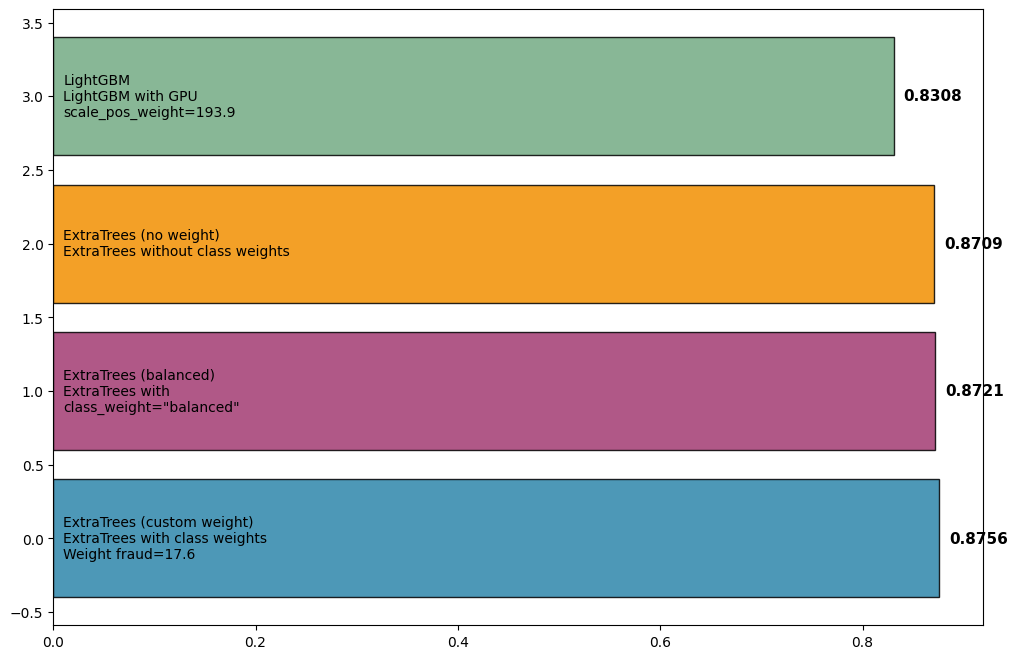

In [46]:
metrics_data = {
    'model': ['LightGBM', 'ExtraTrees (no weight)', 
               'ExtraTrees (custom weight)', 'ExtraTrees (balanced)'],
    'PR-AUC': [test_pr_auc_lgbm, test_pr_auc_none, 
               test_pr_auc_custom, test_pr_auc_balanced],
    'trivia': [
        f'LightGBM with GPU\nscale_pos_weight={best_params['scale_pos_weight']:.1f}',
        f'ExtraTrees without class weights',
        f'ExtraTrees with class weights \nWeight fraud={best_params_custom.get("fraud_weight", 0):.1f}',
        f'ExtraTrees with \nclass_weight="balanced"'
    ]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values('PR-AUC', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(metrics_df)), metrics_df['PR-AUC'], 
                color=['#2E86AB', '#A23B72', '#F18F01', '#73AB84'], 
                alpha=0.85, edgecolor='black')
for i, (bar, pr_auc) in enumerate(zip(bars, metrics_df['PR-AUC'])):
    plt.text(pr_auc + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{pr_auc:.4f}', va='center', fontsize=11, fontweight='bold')
    model_name = metrics_df.iloc[i]['model']
    trivia = metrics_df.iloc[i]['trivia']
    plt.text(0.01, bar.get_y() + bar.get_height()/2, 
             f'{model_name}\n{trivia}', 
             va='center', ha='left', fontsize=10)

### Построение лучшей PR-AUC кривой

In [47]:
from sklearn.metrics import precision_recall_curve, auc

In [48]:
y_test_pred_proba = model_custom.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision) # ~ average_precision_score

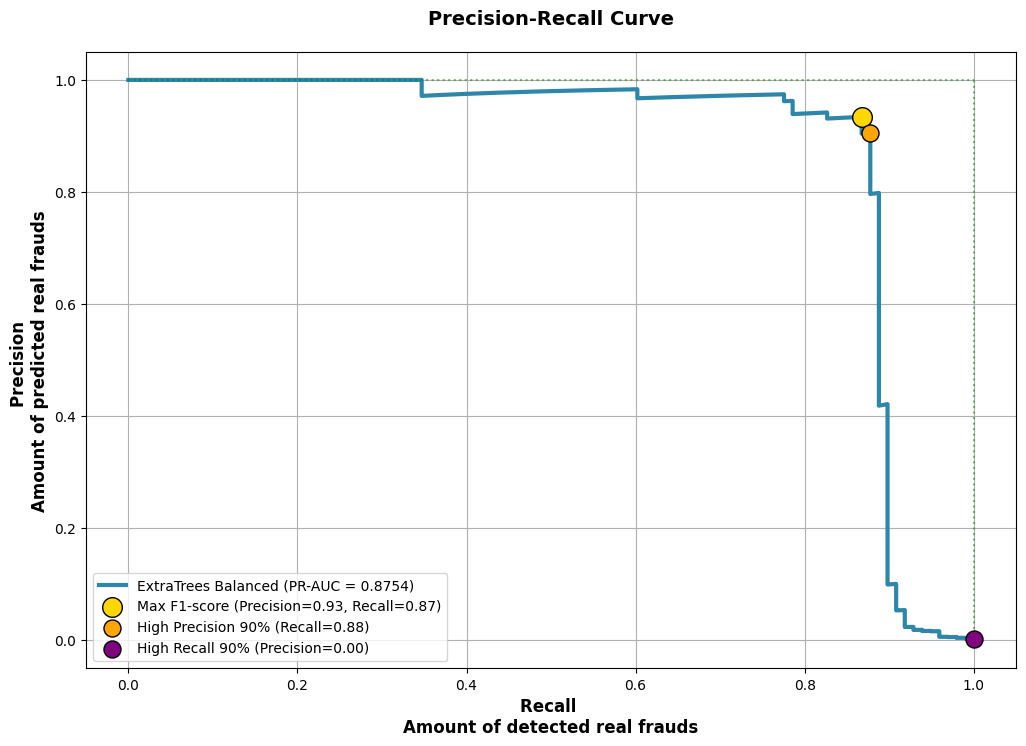

In [63]:
plt.figure(figsize=(12, 8))

plt.plot(recall, precision, linewidth=3, color='#2E86AB', 
         label=f'ExtraTrees Balanced (PR-AUC = {pr_auc:.4f})')
#baseline = y_test.mean()
#plt.axhline(y=baseline, color='red', linestyle='--', linewidth=2, label=f'Baseline = {baseline:.4f}')
plt.plot([0, 1], [1, 1], color='green', linestyle=':', linewidth=1.5, alpha=0.5)
plt.plot([1, 1], [0, 1], color='green', linestyle=':', linewidth=1.5, alpha=0.5)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
plt.scatter(recall[optimal_idx], precision[optimal_idx], s=200, color='gold', edgecolor='black', zorder=5,
            label=f'Max F1-score (Precision={precision[optimal_idx]:.2f}, '
            f'Recall={recall[optimal_idx]:.2f})')

high_precision_idx = np.where(precision >= 0.9)[0][0] if any(precision >= 0.9) else -1
if high_precision_idx != -1:
    plt.scatter(recall[high_precision_idx], precision[high_precision_idx], 
                s=150, color='orange', edgecolor='black', zorder=5,
                label=f'High Precision 90% (Recall={recall[high_precision_idx]:.2f})')
    
high_recall_idx = np.where(recall >= 0.9)[0][0] if any(recall >= 0.9) else -1
if high_recall_idx != -1:
    plt.scatter(recall[high_recall_idx], precision[high_recall_idx], 
                s=150, color='purple', edgecolor='black', zorder=5,
                label=f'High Recall 90% (Precision={precision[high_recall_idx]:.2f})')

plt.xlabel('Recall \nAmount of detected real frauds', fontsize=12, fontweight='bold')
plt.ylabel('Precision \nAmount of predicted real frauds', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.grid(True)
plt.legend(loc='lower left', fontsize=10)

#plt.gca().set_facecolor('#f8f9fa')